In [1]:
import numpy as np
import pandas as pd
from odtlearn.FairTree import FairTreeClassifier
import matplotlib.pyplot as plt

# Fair Optimal Classification Trees
This document aims to demonstrates how to use the `FairTreeClassifier` to fit fair optimal classification trees. We begin with the standard use case, walking through parameter choices and method details, and then provide a small example on a real-world data set.

## `FairTreeClassifier`: the basics

FairTree is an extension of the StrongTree MIO formulation for learning optimal *balanced* classification trees of a given depth that incorporates fairness constraints.

![](../_static/img/fairOCT.png)

## Toy Example 1: enforcing fairness constraints in the MIO formulation

First we generate the data for our example. The diagram within the code block shows the expected structure of the fitted optimal decision tree.
**NEED EXPLANATION OF DIAGRAM HERE**

In [2]:
'''
        X2                    |
        |                     |
        1    5W: 4(-) 1(+)    |     2W: 1(-) 1(+)
        |    2B: 2(-)         |     5B: 3(-) 2(+)
        |                     |    
        |                     |   
        |---------------------|------------------------
        |                     |
        0    4W: 3(-) 1(+)    |         3W: 1(-) 2(+) 
        |    1B:      1(+)    |         6B: 1(-) 5(+)
        |                     | 
        |___________0_________|__________1_____________X1
'''


X = np.array([[0,0],[0,0],[0,0],[0,0],[0,0],
                [1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],
                [1,1],[1,1],[1,1],[1,1],[1,1],[1,1],[1,1],
                [0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]])
P = np.array([0,0,0,0,1,
                0,0,0,1,1,1,1,1,1,
                0,0,1,1,1,1,1,
                0,0,0,0,0,1,1])
y = np.array([0,0,0,1,1,
                0,1,1,0,1,1,1,1,1,
                0,1,0,0,0,1,1,
                0,0,0,0,1,0,0])
P = P.reshape(-1,1)

l = X[:,1]

Let's investigate the following scenarios
   
- We evaluate SP when we don't enforce any fairness constraint
- We evaluate SP when we add SP constraint with fairbound 0.1
- We evaluate PE when we don't enforce any fairness constraint
- We evaluate PE when we add PE constraint with fairbound 0.04

We add a helper function for displaying the results from each scenario

In [3]:
def test_FairTree_metrics(X, y, P, l, f, b):
    fcl = FairTreeClassifier(
        positive_class=1,
        depth=2,
        _lambda=0,
        time_limit=100,
        fairness_type=f,
        fairness_bound=b,
        num_threads=None,
        obj_mode = 'acc'
    )   
    fcl.fit(X, y, P, l, verbose = False)
    
    return fcl

### Evaluating statistical parity without fairness constraint

In [4]:
fcl_wo_SP  = test_FairTree_metrics(X, y, P, l, 'SP', 1)
df_wo_SP = pd.DataFrame(fcl_wo_SP.get_SP(P, fcl_wo_SP.predict(X)).items(), columns=['(p,y)', 'P(Y=y|P=p)'])
print(f'\n{df_wo_SP}\n -------------------------')
fcl_wo_SP.print_tree()
print('The in-sample acc is {}'.format(np.sum(fcl_wo_SP.predict(X)==y)/y.shape[0]))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-05

    (p,y)  P(Y=y|P=p)
0  (0, 0)    0.785714
1  (1, 0)    0.571429
2  (0, 1)    0.214286
3  (1, 1)    0.428571
 -------------------------
#########node  1
branch on X_0
#########node  2
branch on X_0
#########node  3
branch on X_1
#########node  4
leaf 0
#########node  5
leaf 0
#########node  6
leaf 1
#########node  7
leaf 0
The in-sample acc is 0.7142857142857143


[Text(0.5, 0.8333333333333334, 'X_0'),
 Text(0.25, 0.5, 'X_0'),
 Text(0.125, 0.16666666666666666, '0'),
 Text(0.375, 0.16666666666666666, '0'),
 Text(0.75, 0.5, 'X_1'),
 Text(0.625, 0.16666666666666666, '1'),
 Text(0.875, 0.16666666666666666, '0')]

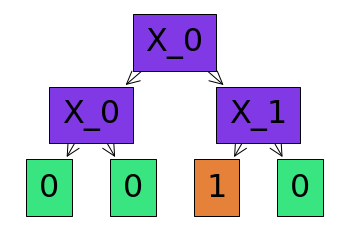

In [5]:
fcl_wo_SP.plot_tree()

### Evaluating statistical parity with fairbound 0.1

In [6]:
fcl_w_SP = test_FairTree_metrics(X, y, P, l, 'SP', 0.1)
df_w_SP = pd.DataFrame(fcl_w_SP.get_SP(P, fcl_w_SP.predict(X)).items(), columns=['(p,y)', 'P(Y=y|P=p)'])
print(f'\n{df_w_SP}\n -------------------------')
fcl_w_SP.print_tree()
print('The in-sample acc is {}'.format(np.sum(fcl_w_SP.predict(X)==y)/y.shape[0]))



    (p,y)  P(Y=y|P=p)
0  (0, 1)         0.5
1  (1, 1)         0.5
2  (0, 0)         0.5
3  (1, 0)         0.5
 -------------------------
#########node  1
branch on X_1
#########node  2
branch on X_0
#########node  3
branch on X_1
#########node  4
leaf 1
#########node  5
leaf 1
#########node  6
leaf 0
#########node  7
leaf 0
The in-sample acc is 0.6785714285714286


[Text(0.5, 0.8333333333333334, 'X_1'),
 Text(0.25, 0.5, 'X_0'),
 Text(0.125, 0.16666666666666666, '1'),
 Text(0.375, 0.16666666666666666, '1'),
 Text(0.75, 0.5, 'X_1'),
 Text(0.625, 0.16666666666666666, '0'),
 Text(0.875, 0.16666666666666666, '0')]

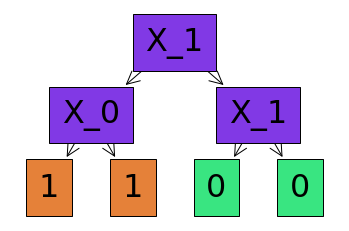

In [7]:
fcl_w_SP.plot_tree()

### Evaluating PE without fairness constraint

In [8]:
fcl_wo_PE  = test_FairTree_metrics(X, y, P, l, 'PE', 1)
df_wo_PE = pd.DataFrame(fcl_wo_PE.get_EqOdds(P, y, fcl_wo_PE.predict(X)).items(), columns=['(p, t, t_pred)', 'P(Y_pred=t_pred|P=p, Y=t)'])
print(f'\n{df_wo_PE}\n -------------------------')
fcl_wo_PE.print_tree()
print('The in-sample acc is {}'.format(np.sum(fcl_wo_PE.predict(X)==y)/y.shape[0]))


  (p, t, t_pred)  P(Y_pred=t_pred|P=p, Y=t)
0      (0, 0, 0)                   0.888889
1      (1, 0, 0)                   0.833333
2      (0, 0, 1)                   0.111111
3      (1, 0, 1)                   0.166667
4      (0, 1, 0)                   0.600000
5      (1, 1, 0)                   0.375000
6      (0, 1, 1)                   0.400000
7      (1, 1, 1)                   0.625000
 -------------------------
#########node  1
branch on X_1
#########node  2
branch on X_0
#########node  3
branch on X_0
#########node  4
leaf 0
#########node  5
leaf 1
#########node  6
leaf 0
#########node  7
leaf 0
The in-sample acc is 0.7142857142857143


[Text(0.5, 0.8333333333333334, 'X_1'),
 Text(0.25, 0.5, 'X_0'),
 Text(0.125, 0.16666666666666666, '0'),
 Text(0.375, 0.16666666666666666, '1'),
 Text(0.75, 0.5, 'X_0'),
 Text(0.625, 0.16666666666666666, '0'),
 Text(0.875, 0.16666666666666666, '0')]

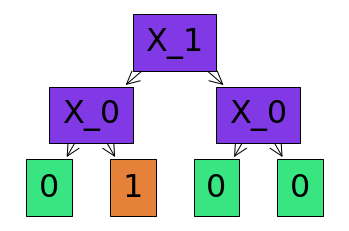

In [9]:
fcl_wo_PE.plot_tree()

### Evaluating PE with fairbound 0.04

In [11]:
fcl_w_PE  = test_FairTree_metrics(X, y, P, l, 'PE', 0.04)
df_w_PE = pd.DataFrame(fcl_w_PE.get_EqOdds(P, y, fcl_w_PE.predict(X)).items(), columns=['(p, t, t_pred)', 'P(Y_pred=t_pred|P=p, Y=t)'])
print(f'\n{df_w_PE}\n -------------------------')
fcl_w_PE.print_tree()
print('The in-sample acc is {}'.format(np.sum(fcl_w_PE.predict(X)==y)/y.shape[0]))


  (p, t, t_pred)  P(Y_pred=t_pred|P=p, Y=t)
0      (0, 0, 0)                        1.0
1      (1, 0, 0)                        1.0
2      (0, 0, 1)                        0.0
3      (1, 0, 1)                        0.0
4      (0, 1, 0)                        1.0
5      (1, 1, 0)                        1.0
6      (0, 1, 1)                        0.0
7      (1, 1, 1)                        0.0
 -------------------------
#########node  1
branch on X_1
#########node  2
branch on X_1
#########node  3
branch on X_0
#########node  4
leaf 0
#########node  5
leaf 0
#########node  6
leaf 0
#########node  7
leaf 0
The in-sample acc is 0.5357142857142857


[Text(0.5, 0.8333333333333334, 'X_1'),
 Text(0.25, 0.5, 'X_1'),
 Text(0.125, 0.16666666666666666, '0'),
 Text(0.375, 0.16666666666666666, '0'),
 Text(0.75, 0.5, 'X_0'),
 Text(0.625, 0.16666666666666666, '0'),
 Text(0.875, 0.16666666666666666, '0')]

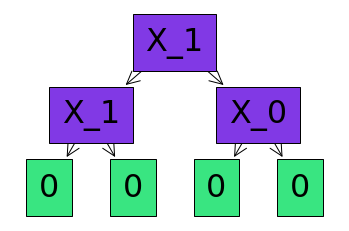

In [12]:
fcl_w_PE.plot_tree()

## References
Jo, N., Aghaei, S., Benson, J., Gómez, A., & Vayanos, P. (2022). Learning optimal fair classification trees. arXiv preprint arXiv:2201.09932. [[arxiv](https://arxiv.org/pdf/2201.09932.pdf)] 